# Wykorzystując rozkład PCA, ICA spróbować wyznaczyć składową oddechową z sygnału EKG.

### Zespół: Krzysztof Wicki, Tomasz Gruzdzis
### Projekt wykonywany na potrzeby przedmiotu "Obliczeniowe podstawy sztucznej inteligencji"


Notatnik prezentuje wykorzystanie metody ICA w celu wyznaczenia składowej oddechowej z sygnału EKG, w literaturze nazywanej EDR z ang. "ECG Derived Respiration".

In [1]:
import numpy as np
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt
import scipy.signal as ss
from scipy import interpolate
from sklearn.decomposition import PCA, FastICA

from data_loader import Loader

In [2]:
loader = Loader()

In [3]:
ecg_data = loader.load_ECG()
br_data = loader.load_BR()

In [4]:
ecg_data

array([[-8.4960938e-02,  1.4403086e+05],
       [-8.4960938e-02,  1.4403086e+05],
       [-7.9101562e-02,  1.4403086e+05],
       ...,
       [-3.7500000e-01,  1.5151217e+05],
       [-1.5234375e-01,  1.5151219e+05],
       [-9.9609375e-02,  1.5151219e+05]], dtype=float32)

In [5]:
res = loader.get_index_of_border_points(2, ecg_data)
start = res['started']
end = res['ended']

In [6]:
ecg_signal = ecg_data[start:end, 0]

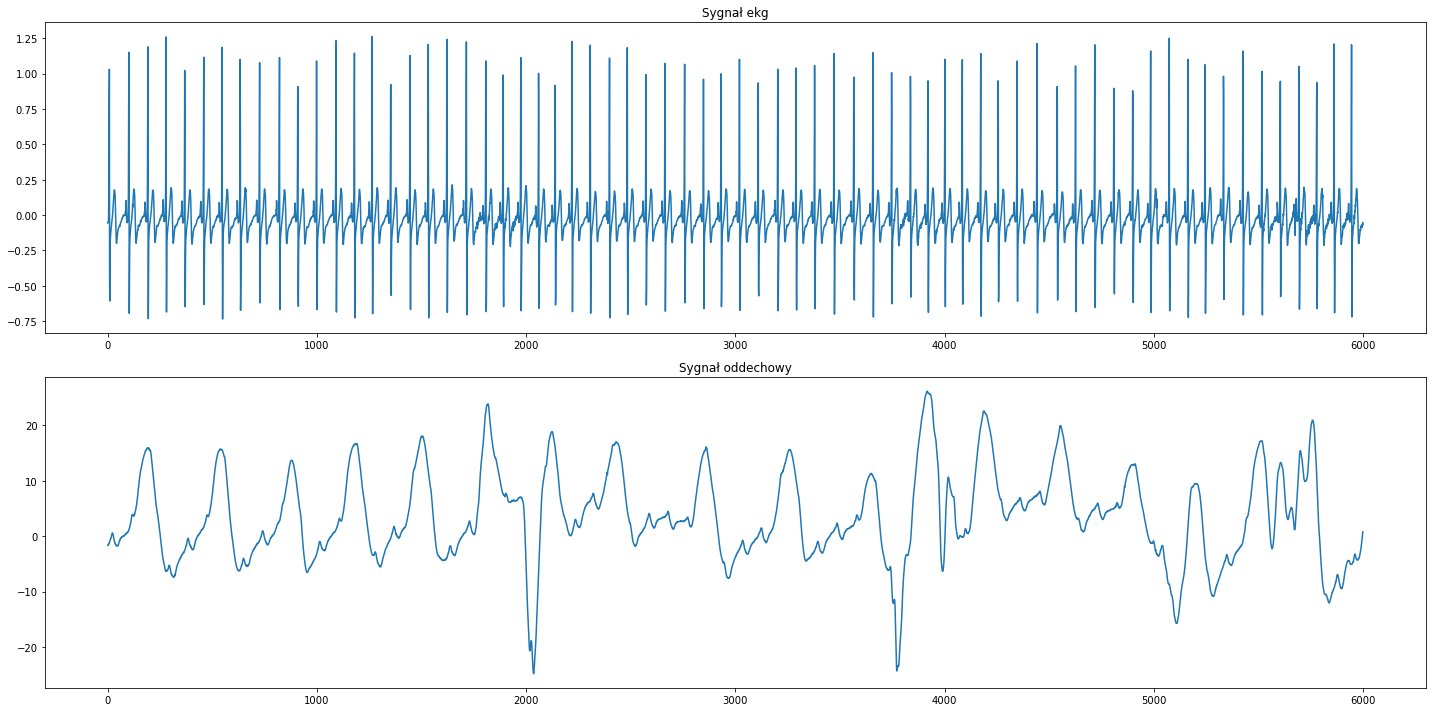

In [7]:
fig, ax = plt.subplots(2, figsize = [20, 10])
ax[0].plot(ecg_signal)
ax[0].set_title('Sygnał ekg')
ax[1].plot(br_data[start:end, 0])
ax[1].set_title('Sygnał oddechowy')

plt.tight_layout()
plt.show()

In [8]:
peakR, _ = ss.find_peaks(ecg_signal)
prominences, _, _ = ss.peak_prominences(ecg_signal, peakR)
selected = prominences > 0.25 * (np.min(prominences) + np.max(prominences))
top = peakR[selected]

In [9]:
fs = 100
window = 20

In [10]:
X_matrix = []
for peak in top:
    if peak < window/2:
        continue
    vector = ecg_signal[(peak-int(window/2)):(peak+int(window/2))]
    X_matrix.append(vector)
X_matrix = np.array(X_matrix)

In [53]:
ecg_signal_croped = ecg_data[start+top[1]:start+top[-1], 0]

In [54]:
time = np.arange(ecg_signal_croped.size) / fs

In [55]:
pca_for_ica = PCA(n_components=10, whiten=True)
buffer = pca_for_ica.fit_transform(X_matrix)

In [56]:
ica10 = FastICA(n_components=10)
ica10.fit(buffer)

FastICA(n_components=10)

In [57]:
trf = ica10.transform(buffer)

In [58]:
trf.shape

(67, 10)

No handles with labels found to put in legend.


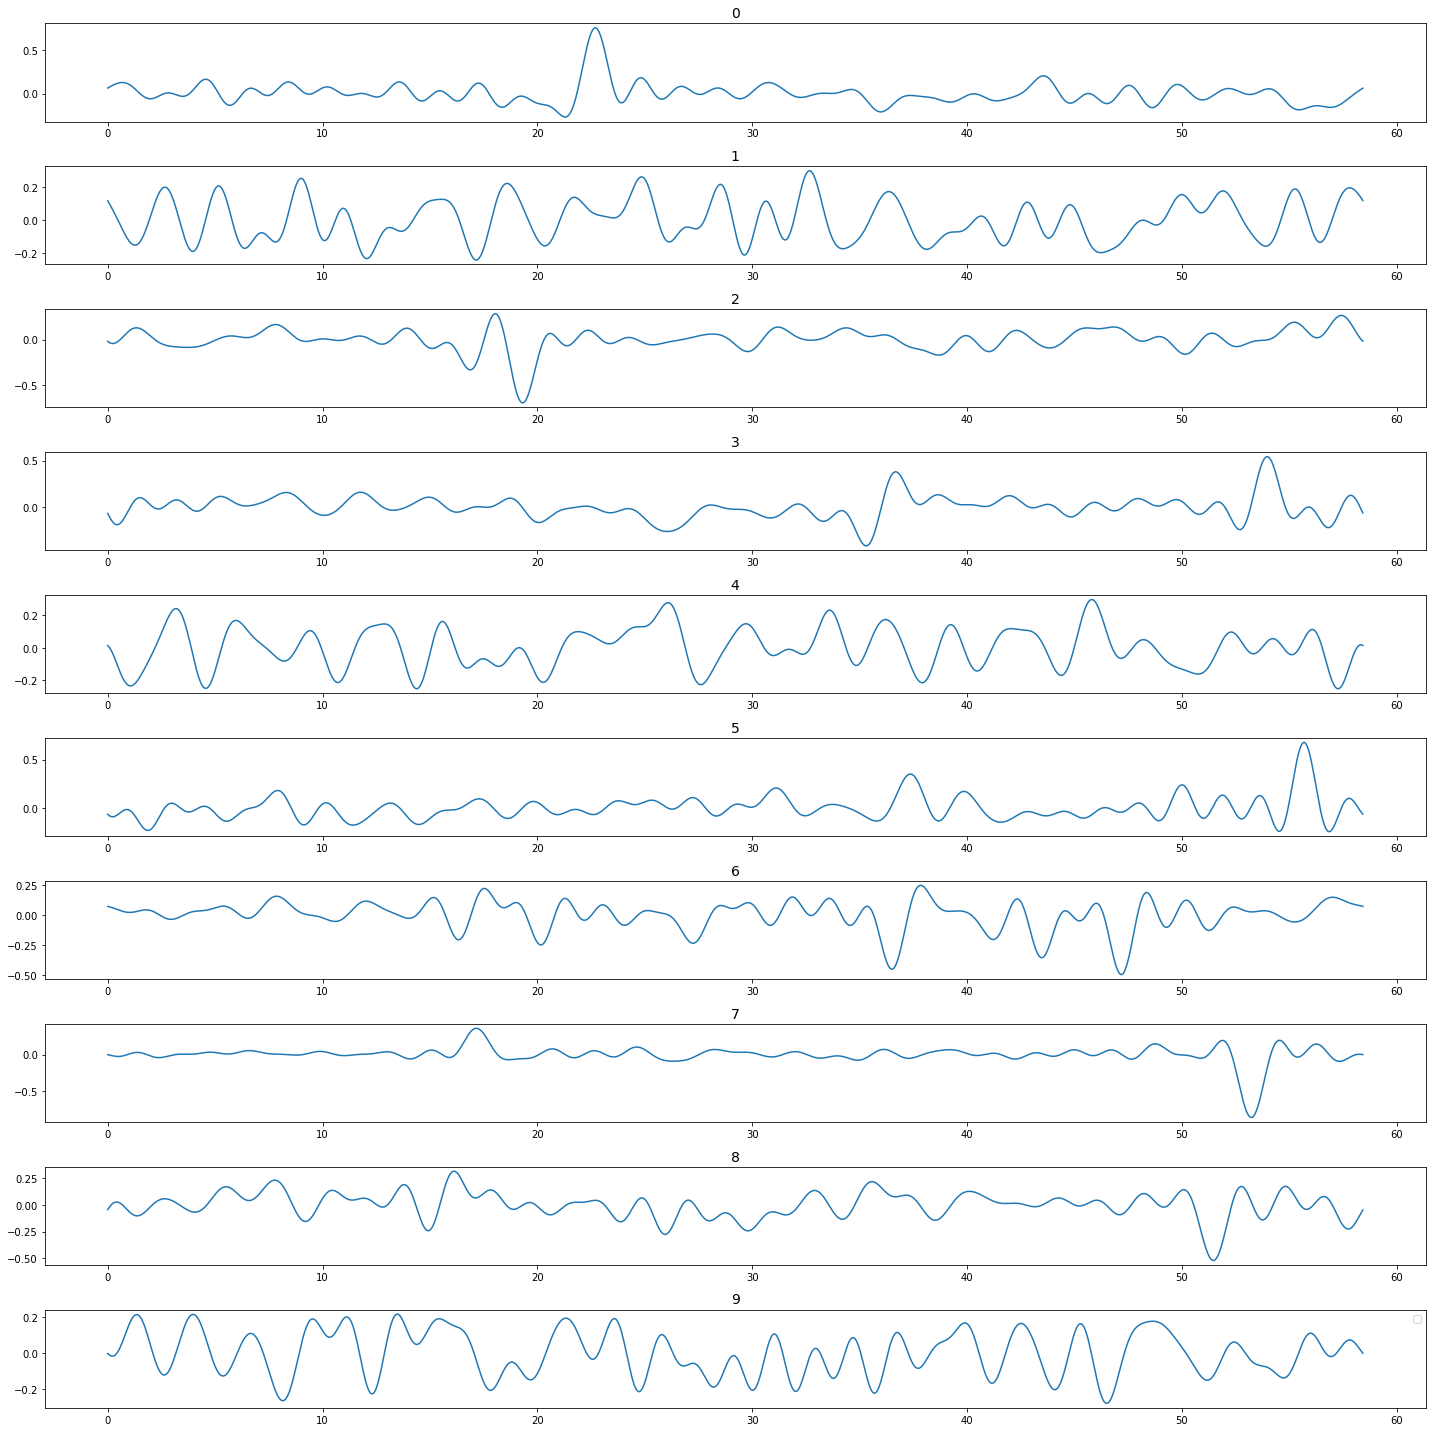

In [59]:
fig, axes = plt.subplots(10, figsize = [20, 20])

for i in range(10):
    fff = ss.resample(trf.T[i], ecg_signal_croped.size)
    axes[i].plot(time, fff)
    axes[i].set_title(str(i), fontsize = 14)

plt.legend()
plt.tight_layout()
plt.show()

No handles with labels found to put in legend.


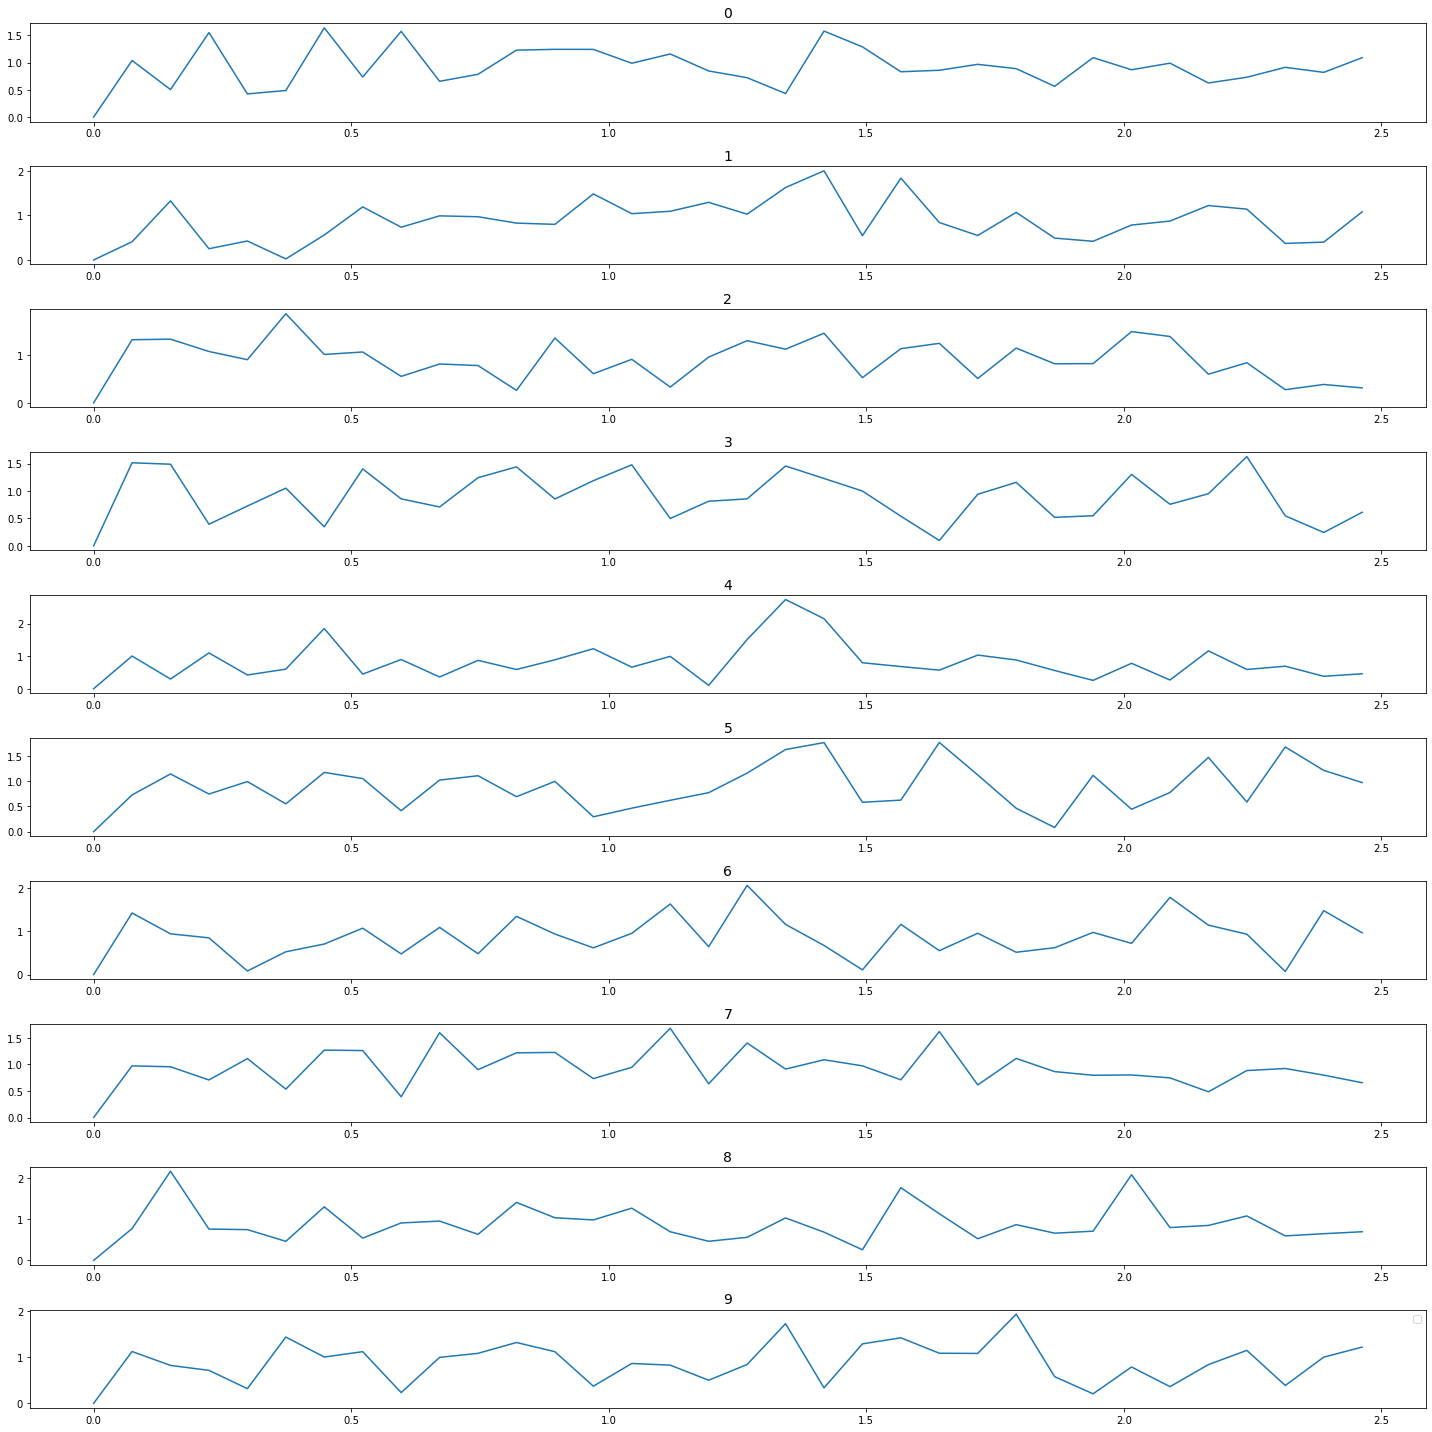

In [65]:
fig, axes = plt.subplots(10, figsize = [20, 20])

from scipy.fft import rfft, rfftfreq, irfft
arrf = []

for i in range(10):
    fff = ss.resample(trf.T[i], ecg_signal_croped.size)
    sample_rate = int(100 / 20)
    yf = rfft(trf.T[i])
    xf = rfftfreq(trf.T[i].size, (1. / sample_rate))

    sos = ss.butter(2, [0.0666, 0.6], 'bandpass', output='sos')

    filtered = ss.sosfilt(sos, yf)
    arrf.append(filtered)
    
    axes[i].plot(xf, abs(yf))
    axes[i].set_title(str(i), fontsize = 14)

plt.legend()
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Sygnał oddechowy')

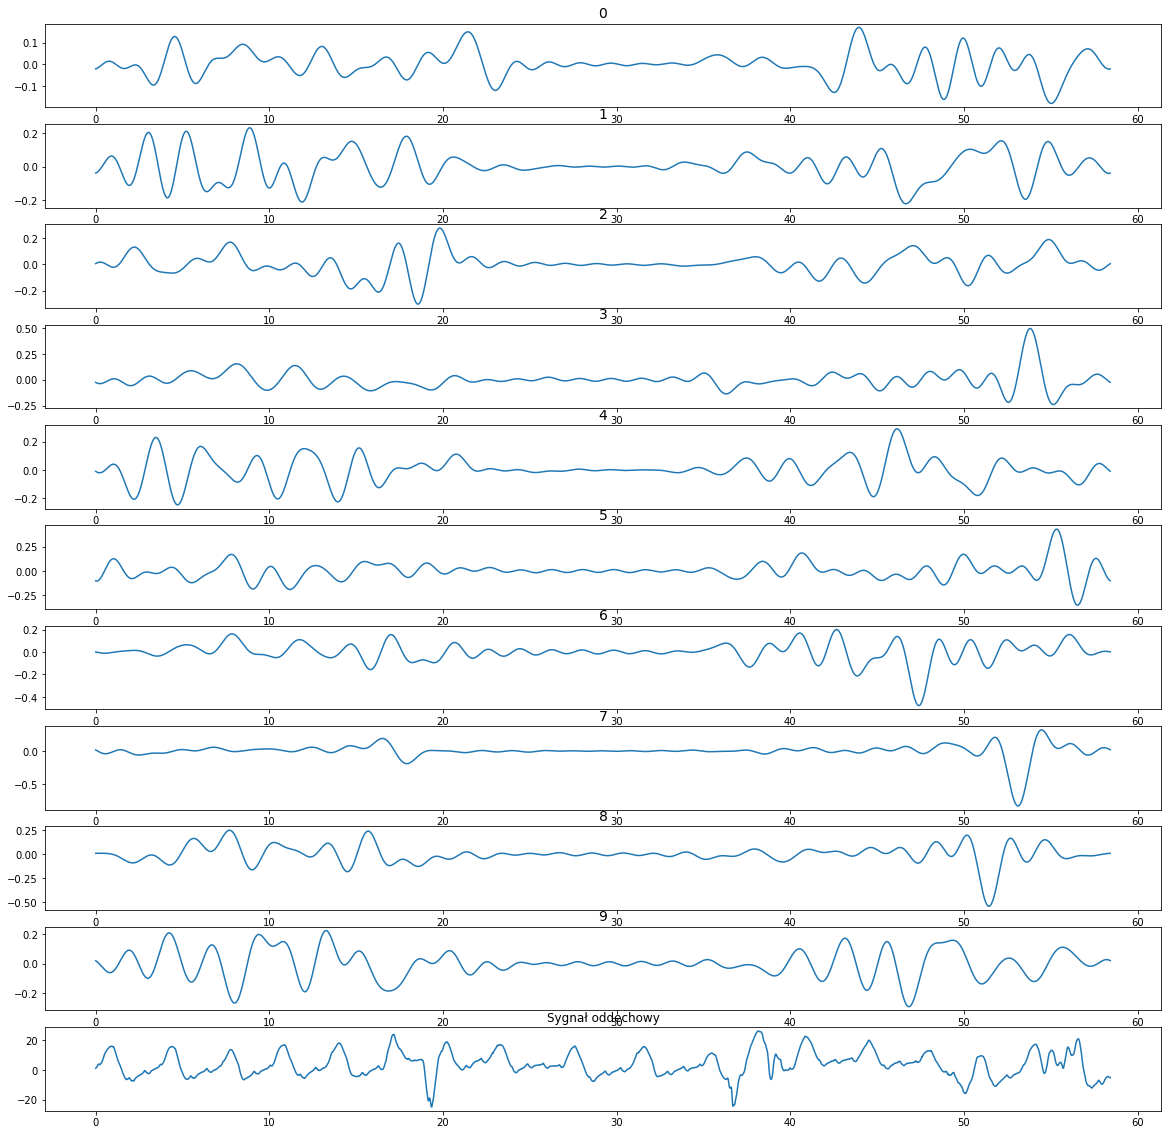

In [66]:
from scipy.fft import irfft
fig, axes = plt.subplots(11, figsize = [20, 20])

for i in range(10):
    new_sig = irfft(arrf[i])
    new_sig = ss.resample(new_sig, ecg_signal_croped.size)

    axes[i].plot(time, new_sig)
    axes[i].set_title(str(i), fontsize = 14)
axes[10].plot(time, br_data[start+top[1]:start+top[-1], 0])
axes[10].set_title('Sygnał oddechowy')


Otrzymane sygnały przypominają ten referencyjny sygnał oddechowy, różnice widoczne są w otrzymanych amplitudach - te wypadają normalnie względem publikacyjnych, częstotliwości sygnałów EDR pokrywają się z sygnałem oddechowym.